In [1]:
from urllib.request import urlopen
import urllib
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import json

# Aircraft Classification

Here I train a convolutional neural net to classify different aircraft types. First I begin with binary classification of b737 vs b747, then generalize it to all aircrafts.

## End goal & Data Source

Why am I doing this? The end goal is to develop a smartphone app that can classify airplanes by taking a picture of an aircraft. For a successful app, this means the user must be able take the picture from any angle (assuming a reasonable angle, i.e not from undernearth, etc.). This however means that I need massive amounts of data to cover all angles. For this, I rely on web scraping from https://www.airplane-pictures.net/search.php?p=b+737&Submit=Search  

### Domain Knowledge

The reason why I chose B 737 vs B 747 as a practice is because they have very distinct looks. B 737's body is a cylindrical tube with near constant diameter while B 747 expands in diameter near the front ends. This distinction will help with classification, as opposed to say classifying Boeing 737 vs airbus a320, which look very similar to each other.

## B 737 vs B 747
Perform:    
1. Web scraping images of planes from https://www.airplane-pictures.net/search.php?p=b+737&Submit=Search
2. Data Pre-Processing
3. Model fitting  

## Web scraping % parsing

data source: https://www.airplane-pictures.net/search.php?p=b+737&Submit=Search  


In [2]:
def download(url, pg, output_folder):
    """download and store images"""
    
    # parse html
    html = urlopen(url)
    bs = BeautifulSoup(html, 'html.parser')
    images = bs.find_all('img', {'src':re.compile('.jpg')})
    
    
    store={} # store info about the downloads
    for e,image in enumerate(images):
        store_={}
        store_['src']=image['src']
        store_['title']=image['title']
        store[e]=store_
        
        urllib.request.urlretrieve(image['src'], ".\\planes\\%s\\pg=%s_%s.jpg" % (output_folder,pg,e))
    
    with open(".\\planes\\%s\\scraping_info_pg=%s.txt" % (output_folder, pg), 'w') as outfile:
        json.dump(store, outfile)

## Download B 737

In [102]:
for i in range(1,100): # iterate over the page number.
    assert False # prevent accidental run
    output_folder="b737"
    query="b+737"
    pg=i
    url="https://www.airplane-pictures.net/search.php?p="+query+"&pg="+str(pg)+"&order=screen_timestamp"

    download(url, pg, output_folder)

## Download B 747

In [106]:
for i in range(1,100): # iterate over the page number
    assert False # prevent accidental run
    output_folder="b747"
    query="b+747"
    pg=i
    url="https://www.airplane-pictures.net/search.php?p="+query+"&pg="+str(pg)+"&order=screen_timestamp"

    download(url, pg, output_folder)

## Pre-Processing

### dimension analysis

Not all images will have the same dimensions. Here I investigate the distribution of dimensions.

In [3]:
import glob
import imageio
import numpy as np

In [4]:
b737=glob.glob(".\\planes\\b737\\*.jpg")
b747=glob.glob(".\\planes\\b747\\*.jpg")

In [5]:
print( len(b737), len(b747))

4950 4950


In [6]:
list1=[]
for i in b737:
    img = imageio.imread(i)
    list1.append(img.shape)
unique, counts=np.unique(np.array(list1), return_counts=True)

In [7]:
# key: dimension, value: number of images of matching the dimension
unique_count={i:j for i,j in zip(unique, counts)}
unique_count

{(232, 130, 3): 1,
 (232, 149, 3): 1,
 (232, 154): 1,
 (232, 154, 3): 3,
 (232, 155, 3): 1,
 (232, 159, 3): 1,
 (232, 174, 3): 4,
 (232, 185, 3): 1,
 (232, 211, 3): 1,
 (232, 231, 3): 3,
 (232, 232, 3): 1,
 (232, 282, 3): 1,
 (232, 285, 3): 1,
 (232, 290, 3): 1,
 (232, 297, 3): 1,
 (232, 303, 3): 3,
 (232, 304, 3): 1,
 (232, 305, 3): 3,
 (232, 307, 3): 1,
 (232, 309, 3): 129,
 (232, 310, 3): 1,
 (232, 311, 3): 1,
 (232, 312, 3): 1,
 (232, 313, 3): 1,
 (232, 314, 3): 3,
 (232, 316, 3): 1,
 (232, 317, 3): 2,
 (232, 318, 3): 3,
 (232, 320, 3): 4,
 (232, 321, 3): 2,
 (232, 322, 3): 3,
 (232, 323, 3): 2,
 (232, 324, 3): 4,
 (232, 325, 3): 3,
 (232, 326, 3): 3,
 (232, 327, 3): 5,
 (232, 329, 3): 2,
 (232, 330, 3): 3,
 (232, 331, 3): 2,
 (232, 332, 3): 4,
 (232, 333, 3): 3,
 (232, 334, 3): 5,
 (232, 335, 3): 6,
 (232, 336, 3): 3,
 (232, 337, 3): 3,
 (232, 338, 3): 9,
 (232, 339, 3): 2,
 (232, 340, 3): 5,
 (232, 341, 3): 5,
 (232, 342, 3): 61,
 (232, 343, 3): 9,
 (232, 344, 3): 6,
 (232, 345, 

Image sizes look pretty scattered out, but some big clusters exist. Here I have several options:
1. compress all the images to a fixed size
2. cut all the images to the a fixed size
3. perform analysis only on one big cluster of data, with the same dimensions

1 is not favorable because there is too much spatial information loss when compressing. 3 means there will be fewer data. Therefore 2 is the ideal case, with an acknowledgement that some planes will be cut in some parts. I will choose the smallest cluster and cut all images to that size.

Additionally, some of the images only have a single channel, hence they will be removed as well.

### filter 1
0. Filter out single channel images
1. If resolution is below 232x309x3 discard
2. cut all images to the size 232x309x3

In [9]:
import scipy
import scipy.misc

In [10]:
def filter1(pathA, pathB):
    "applies filter to images in folders and save it to a different location"
    IMG_A, IMG_B=[],[]
    countA=0
    countB=0
    for a,b in zip(pathA, pathB):
        img_A=imageio.imread(a)
        img_B=imageio.imread(b)
        
        #step 0
        
        # B 737
        if np.ndim(img_A)==3:
            # step 1
            sp=np.shape(img_A)
            assert sp[0]==232
            if sp[1]>=309:
                diff=sp[1]-309
                if diff % 2 == 0: # even
                    scipy.misc.imsave(".\\planes\\b737_filter1\\"+a.split("\\")[-1], img_A[:, diff//2 : sp[1]-diff//2,:])
                elif diff % 2 == 1: # odd
                    scipy.misc.imsave(".\\planes\\b737_filter1\\"+a.split("\\")[-1], img_A[:, diff//2+1 : sp[1]-diff//2,:])
            
            else:
                countA+=1
            
        # B 747
        if np.ndim(img_B)==3:
            # step 1
            sp=np.shape(img_B)
            assert sp[0]==232
            if sp[1]>=309:
                diff=sp[1]-309
                if diff%2==0:
                    scipy.misc.imsave(".\\planes\\b747_filter1\\"+a.split("\\")[-1], img_B[:,diff//2 : sp[1]-diff//2,:])
                elif diff%2==1:
                    scipy.misc.imsave(".\\planes\\b747_filter1\\"+a.split("\\")[-1], img_B[:,diff//2+1 : sp[1]-diff//2,:])
            else:
                countB+=1
    print("omitted pictures, A,B respectively: ",countA, countB)

apply filter and save the images into a different folder

In [76]:
if False: # prevent accidental run
    filter1(b737, b747)

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


omitted pictures, A,B respectively:  29 50


## filter2: Duplicates

duplicates spread acorss both training set and test set causes a huge problem when it comes to deep learning models. Here I remove images that close match one another.

In [90]:
# to be implemented

## Training

In [1]:
import numpy as np
import pandas
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPool2D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import matplotlib.pyplot as plt

#from keras.layers.convolutional import UpSampling2D, Conv2D

import glob
import imageio
import scipy.misc

Using TensorFlow backend.


In [35]:
class airplane_classify():
    def __init__(self):
        self.imgsize=(232,309,3)
        pathA=glob.glob(".\\planes\\b737_filter1\\*.jpg")
        pathB=glob.glob(".\\planes\\b747_filter1\\*.jpg")
        
        self.trainA = pathA[:3500]
        self.trainB = pathB[:3500]
        
        self.batch_size=32
        self.model=self.build_model()
        
        
    def build_model(self):
        model=Sequential()
        model.add(Conv2D(32, (5,5), padding='same' ,activation='relu', input_shape=(232,309,3)))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Conv2D(64, (3,3), padding='same' ,activation='relu'))
        model.add(MaxPool2D(pool_size=(5,5)))
        model.add(Conv2D(128, (2,2), padding='same' ,activation='relu'))
        model.add(MaxPool2D(pool_size=(7,7)))
        model.add(Flatten())
        model.add(Dense(units=64, activation = 'relu'))
        model.add(Dense(units=32, activation = 'relu'))
        model.add(Dense(units=1, activation='sigmoid'))

        #run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        
        return model
    
    def load_batch(self, batch_size=32):
        # load each batch of size 64, half containing b737 and the other half containing b747
        n_batch=int( min( len(self.trainA)/(batch_size), len(self.trainB)/batch_size ) )
        sample_size=n_batch*batch_size
        pathA=np.random.choice(self.trainA, sample_size, replace=False)
        pathB=np.random.choice(self.trainB, sample_size, replace=False)
        
        for i in range(n_batch-1):
            img=[]
            batchA = pathA[ i*batch_size : (i+1)*batch_size ]
            batchB = pathB[ i*batch_size : (i+1)*batch_size ]
            
            for a,b in zip(batchA, batchB):
                imgA=imageio.imread(a)
                imgB=imageio.imread(b)
                
                img.append(imgA)
                img.append(imgB)
            yield np.array(img)/127.5-1
            
            
    def train(self, epochs=1):
        
        label=np.zeros(2*self.batch_size)
        label[1::2]=1
        for epoch in range(epochs):
            for train_set in self.load_batch():
                loss=self.model.train_on_batch(train_set,label)
            print("epoch: %s;  loss: %s;  accuracy: %s" %(epoch, loss[0], loss[1]))
        return self.model


In [36]:
classify=airplane_classify()
model=classify.train(epochs=8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 232, 309, 32)      2432      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 116, 154, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 116, 154, 64)      18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 23, 30, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 23, 30, 128)       32896     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 3, 4, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1536)              0         
__________

## Testing

In [37]:
pathA=glob.glob(".\\planes\\b737_filter1\\*.jpg")
pathB=glob.glob(".\\planes\\b747_filter1\\*.jpg")

testA =  pathA[3500:]
testB =  pathB[3500:]
        
batch_size=32
n_batch=int( min( len(testA)/batch_size, len(testB)/batch_size ) )
sample_size=n_batch*batch_size
pathA=np.random.choice(testA, sample_size, replace=False)
pathB=np.random.choice(testB, sample_size, replace=False)

def load_batch(pathA, pathB):
    for i in range(n_batch-1):
        img=[]
        batchA = pathA[ i*batch_size : (i+1)*batch_size ]
        batchB = pathB[ i*batch_size : (i+1)*batch_size ]

        for a,b in zip(batchA, batchB):
            imgA=imageio.imread(a)
            imgB=imageio.imread(b)

            img.append(imgA)
            img.append(imgB)
        yield np.array(img)/127.5-1

In [38]:
label=np.zeros(2*batch_size)
label[1::2]=1

for e,i in enumerate(load_batch(pathA, pathB)):    
    if e%3==0:
        l=model.evaluate(i,label)
        print("batch number: %s; loss: %s, accuracy: %s" %(e, l[0], l[1]))

64/64 [==============================] - 0s 5ms/step
batch number: 0; loss: 0.20786872506141663, accuracy: 0.921875
64/64 [==============================] - 0s 3ms/step
batch number: 3; loss: 0.3215450197458267, accuracy: 0.875
64/64 [==============================] - 0s 2ms/step
batch number: 6; loss: 0.23430565744638443, accuracy: 0.90625
64/64 [==============================] - 0s 2ms/step
batch number: 9; loss: 0.531327560544014, accuracy: 0.8125
64/64 [==============================] - 0s 2ms/step
batch number: 12; loss: 0.36159251630306244, accuracy: 0.890625
64/64 [==============================] - 0s 2ms/step
batch number: 15; loss: 0.22144678235054016, accuracy: 0.9375
64/64 [==============================] - 0s 2ms/step
batch number: 18; loss: 0.21684207767248154, accuracy: 0.90625
64/64 [==============================] - 0s 2ms/step
batch number: 21; loss: 0.16886117309331894, accuracy: 0.96875
64/64 [==============================] - 0s 2ms/step
batch number: 24; loss: 0.23

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

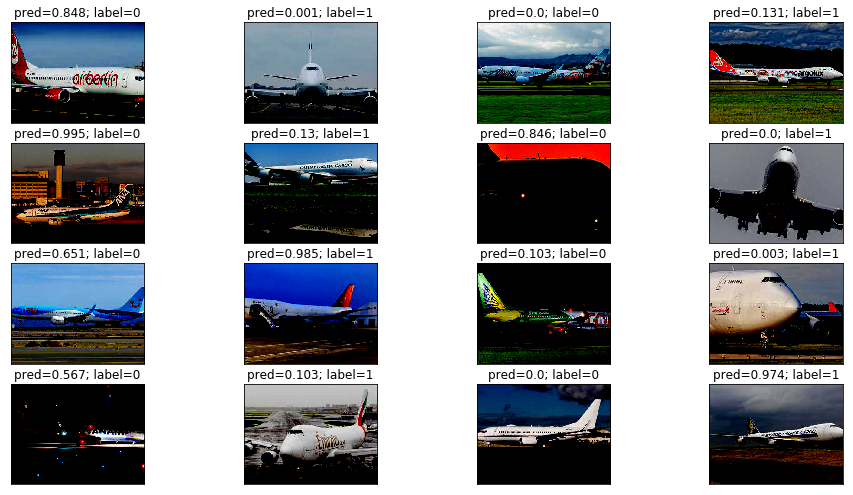

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

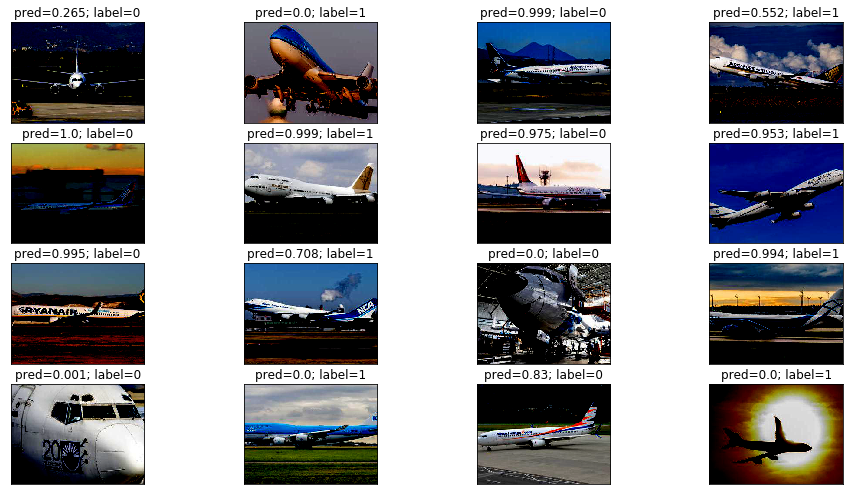

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

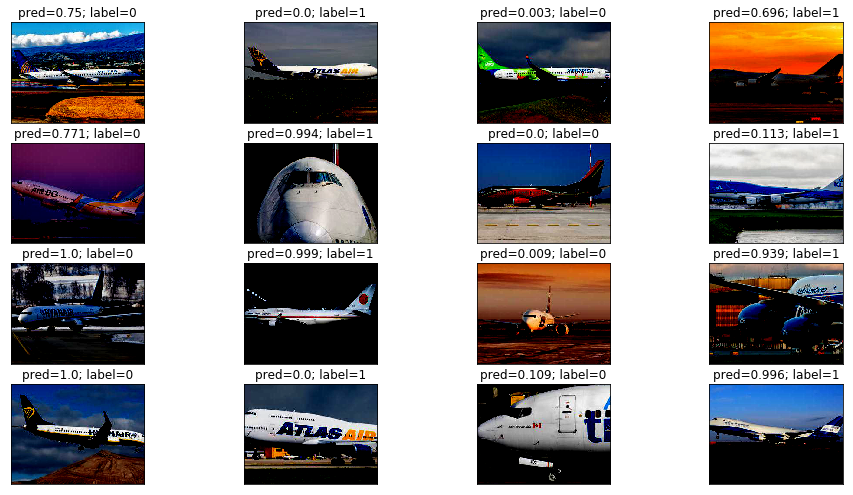

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

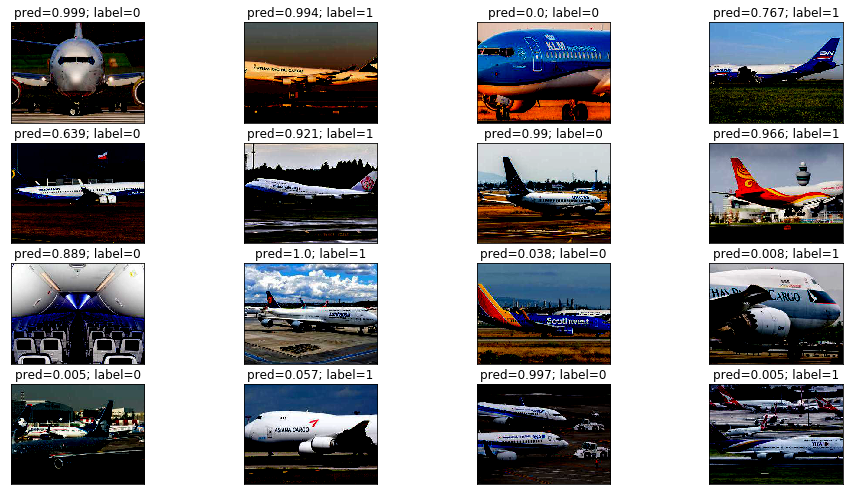

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

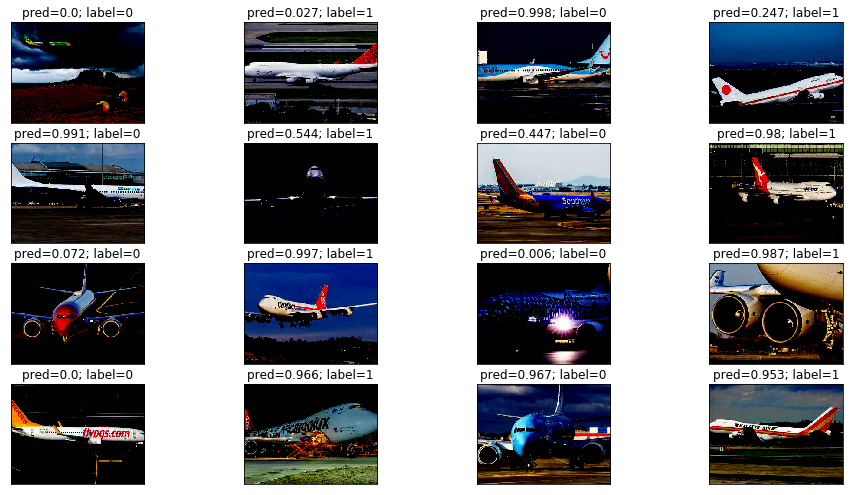

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

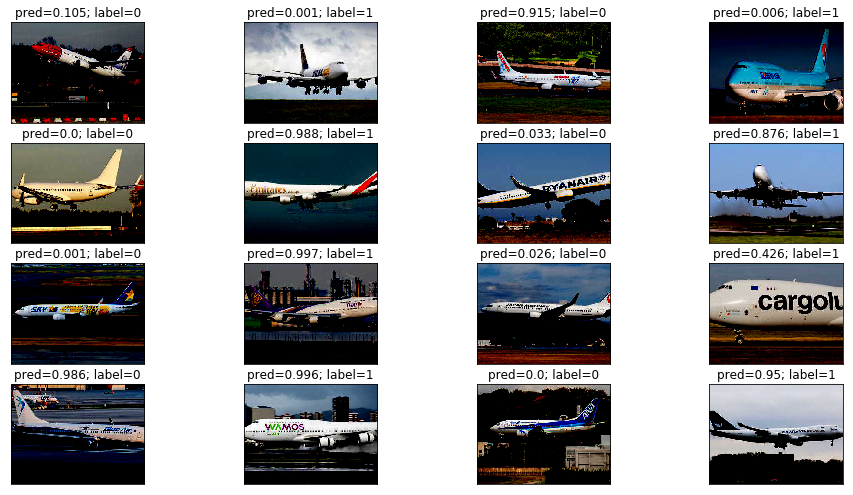

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

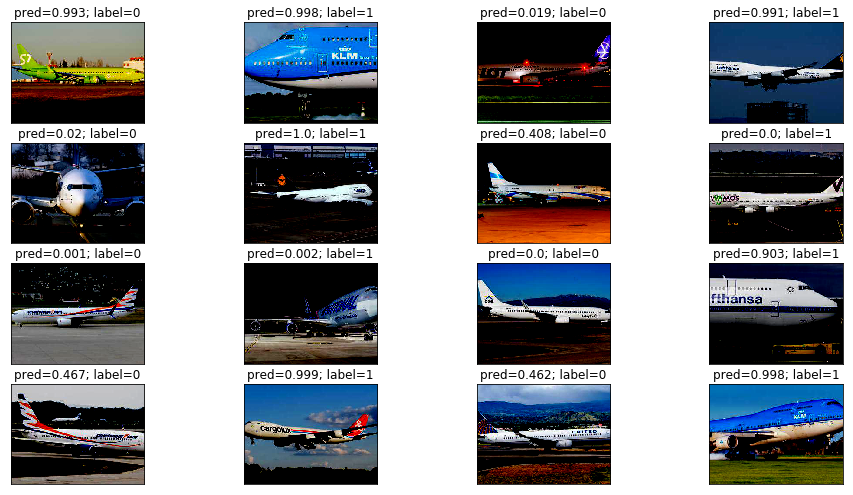

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

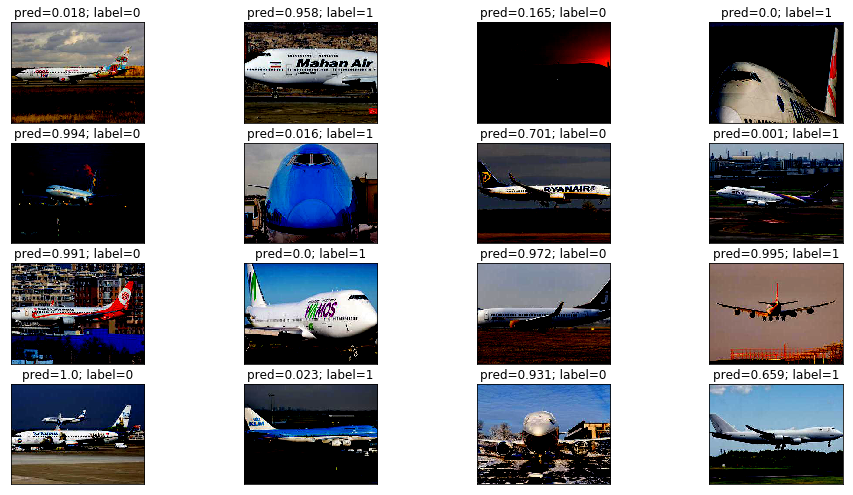

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

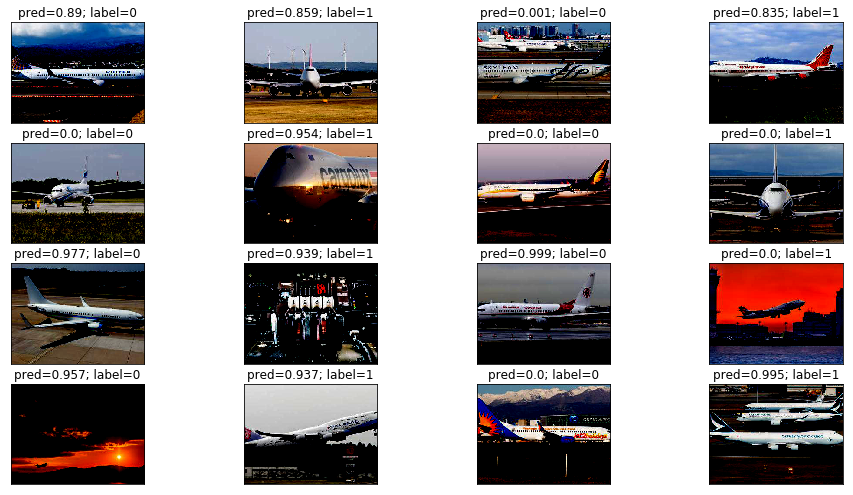

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

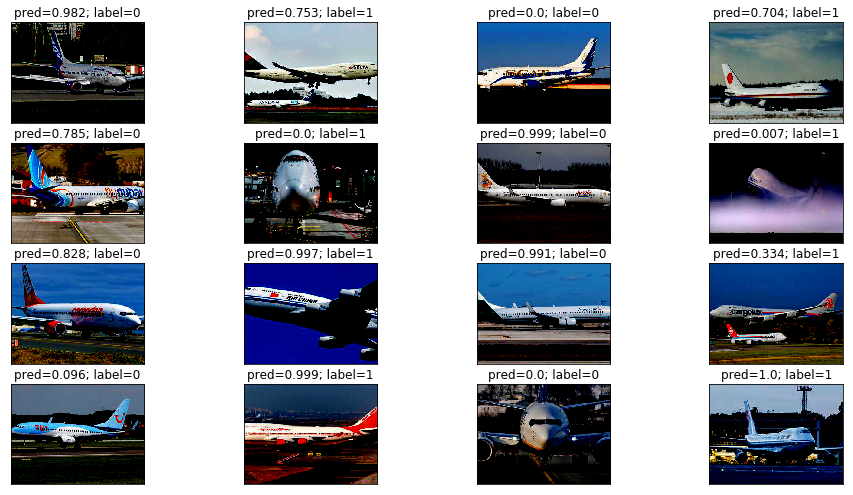

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

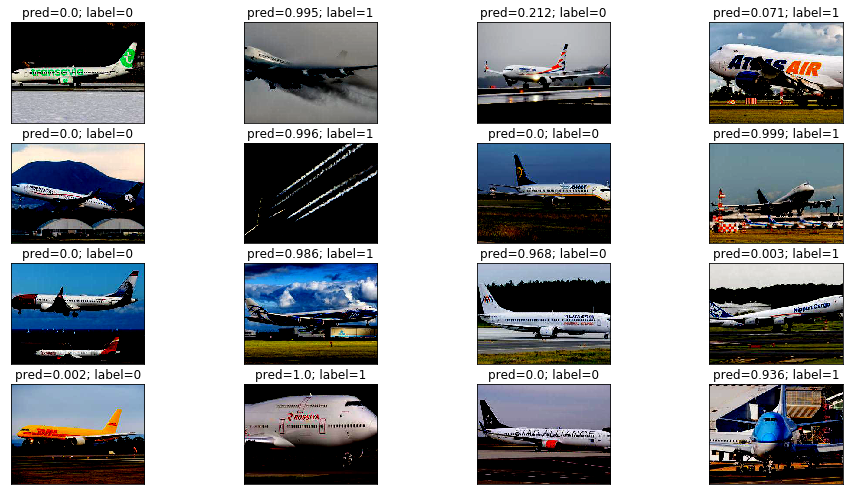

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

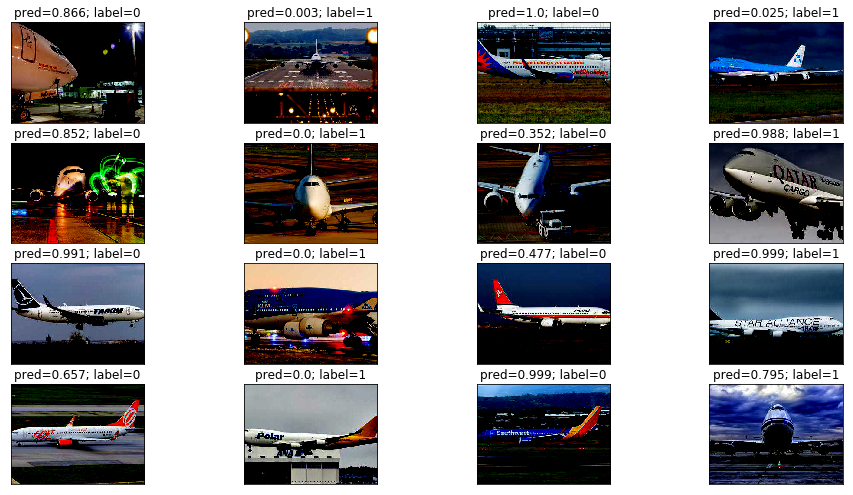

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

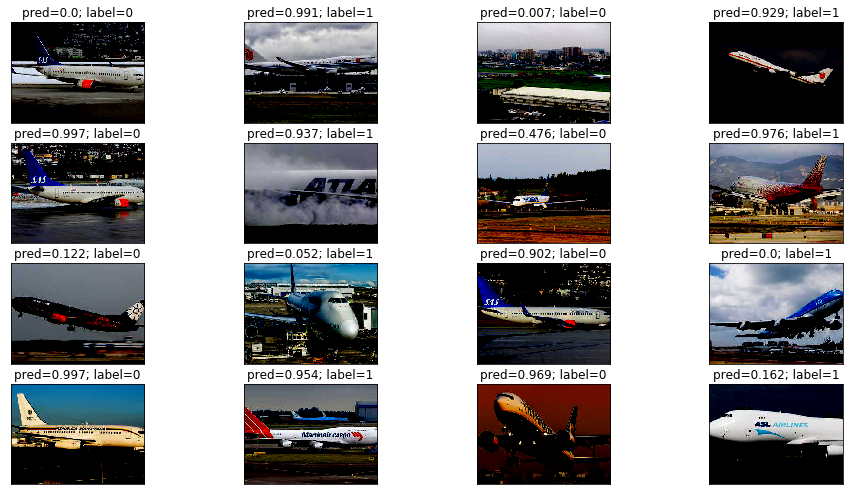

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

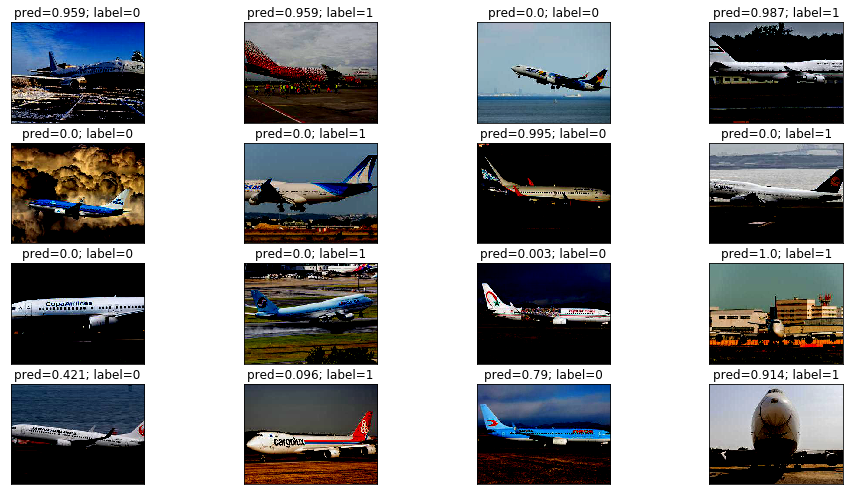

In [39]:
for e,i in enumerate(load_batch(pathA, pathB)):    
    if e%3==0:
        flip_batch=[]
        for y in i:
            if np.random.random()>0.5:
                flip_batch.append(np.fliplr(y))
        
        p=model.predict(np.array(flip_batch))
        fig,ax=plt.subplots(4,4,figsize=[16,8.5])
        for j in range(16):
            i1=j//4
            i2=j%4
            ax[i1][i2].imshow(i[j])
            ax[i1][i2].set_title("pred="+str(round(p[j][0],3))+"; "+"label="+str(j%2))
            ax[i1][i2].set_xticks([])
            ax[i1][i2].set_yticks([])
        plt.show()